# HAPI - Plotting

- https://hapi-server.org/
- https://github.com/heliophysicsPy/summer-school-24/tree/main/hapi-tutorial

In [ ]:
import sys
import warnings; warnings.simplefilter('ignore')

## Availability of ephemeris (position) data from the SSCWeb HAPI server

Write a program that creates the information in the dictionary `datasets` by querying the SSCWeb HAPI server.

### Solution 1

In [ ]:
import requests

url = "https://hapi-server.org/servers/SSCWeb/hapi/catalog"
response = requests.get(url)
data = response.json()
data.keys()

dict_keys(['catalog', 'HAPI', 'status'])

In [ ]:
catalog = data['catalog'].copy()
print(len(catalog))
catalog[:3]

298


[{'id': 'ace', 'title': 'ACE'},
 {'id': 'active', 'title': 'Active'},
 {'id': 'aec', 'title': 'AE-C'}]

In [ ]:
from tqdm import tqdm

In [ ]:
datasets = []

for sample in tqdm(catalog):
    tmp = sample.copy()
    url = f"https://hapi-server.org/servers/SSCWeb/hapi/info?id={tmp['id']}"
    response = requests.get(url)
    data = response.json()
    
    tmp['startDate'] = data['startDate']
    tmp['stopDate'] = data['stopDate']
    datasets.append(tmp)

100%|██████████| 298/298 [03:51<00:00,  1.29it/s]


In [ ]:
import pickle

with open('availability.pkl', 'wb') as f:
    pickle.dump(datasets, f)

### Solution 2

In [ ]:
from hapiclient import hapi

server = 'https://hapi-server.org/servers/SSCWeb/hapi'
resp = hapi(server)
datasets = resp['catalog']

# Note that this require one request to the HAPI server for metadata for each dataset and some servers have 2000+ datasets.
# An alternative to this approach is to use the JSON files create by a crawlers that builds a metadata table for each HAPI server.
# See https://github.com/hapi-server/servers/tree/master/index.
for idx, dataset in tqdm(enumerate(datasets), total=len(datasets)):
    resp = hapi(server, dataset["id"], logging=False)
    startDate = resp["startDate"]
    stopDate = resp["stopDate"]
    # Add start/stop to each element in datasets list
    datasets[idx]["startDate"] = startDate
    datasets[idx]["stopDate"] = stopDate

# Save result so we don't need to recreate when we modify table and plot code.
with open('availability2.pkl', 'wb') as f:
    pickle.dump(datasets, f)

100%|██████████| 298/298 [04:48<00:00,  1.03it/s]


## Load



In [ ]:
import pickle

with open('availability.pkl', 'rb') as f:
    datasets1 = pickle.load(f)

with open('availability2.pkl', 'rb') as f:
    datasets2 = pickle.load(f)

In [ ]:
import numpy as np

for d1, d2 in zip(datasets1, datasets2):
    assert d1 == d2

## Plot

Create a table and plot showing the time interval of availability of ephemeris data from the SSCWeb HAPI server.

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

from hapiplot.plot.datetick import datetick
from hapiclient import hapitime2datetime

In [ ]:
server = 'https://hapi-server.org/servers/SSCWeb/hapi'
ids = []
starts = []
stops = []
n_max = len(datasets)
# n_max = 50 # Plot only first n_max datasets

# Create table
n = 0
datasets.reverse()
table = []
for idx, dataset in enumerate(datasets):
    # Pad ids. Assumes max id length is 14 chars.
    id = datasets[idx]["id"]
    idp = '{0:15s}'.format(id)
    line = f'{idp}  {datasets[idx]["startDate"]}  {datasets[idx]["stopDate"]}'
    table.append(line)

    ids.append(id)
    starts.append(hapitime2datetime(datasets[idx]["startDate"])[0])
    stops.append(hapitime2datetime(datasets[idx]["stopDate"])[0])
    n = n + 1
    if n > n_max:
        break

sys.stdout.flush()

with open('availability.txt', 'w', encoding = 'utf-8') as f:
    f.write("Table created on " + datetime.now().isoformat() + "\n\n")
    f.write("\n".join(table))

In [ ]:
def newfig():
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(8)
    return ax

def figconfig(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', which='minor', alpha=0.5, linestyle=':')
    ax.grid(axis='x', which='major', color='k', alpha=0.5)
    ax.set_yticks(ticks=[])
    ax.set_title(f'{server}')
    datetick('x')

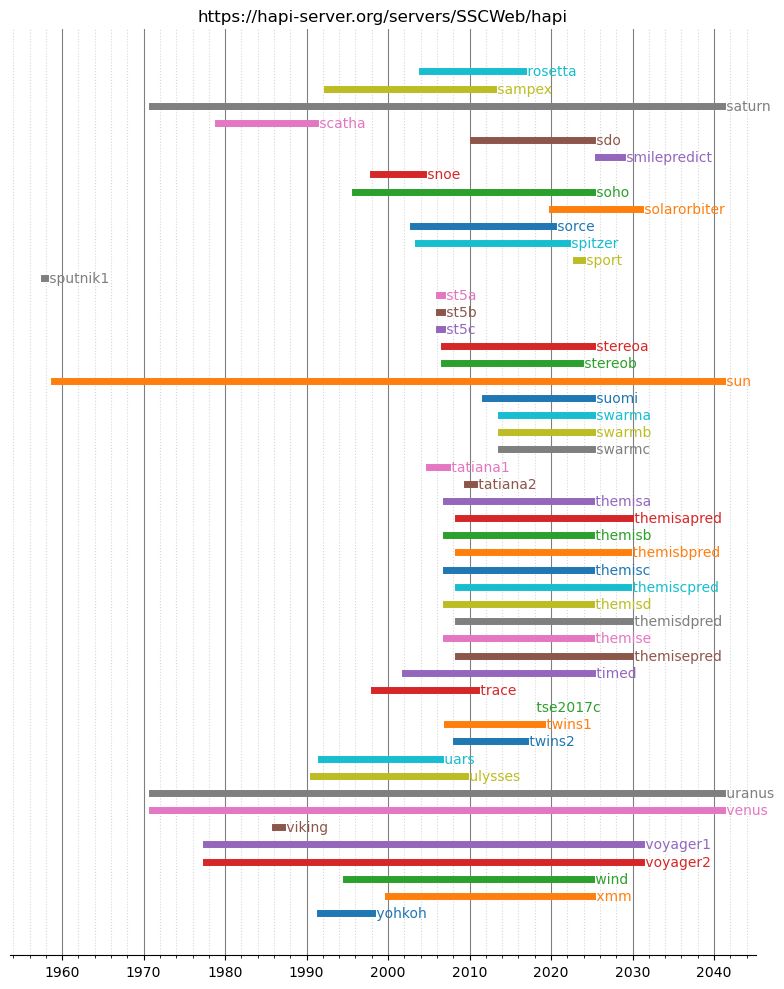

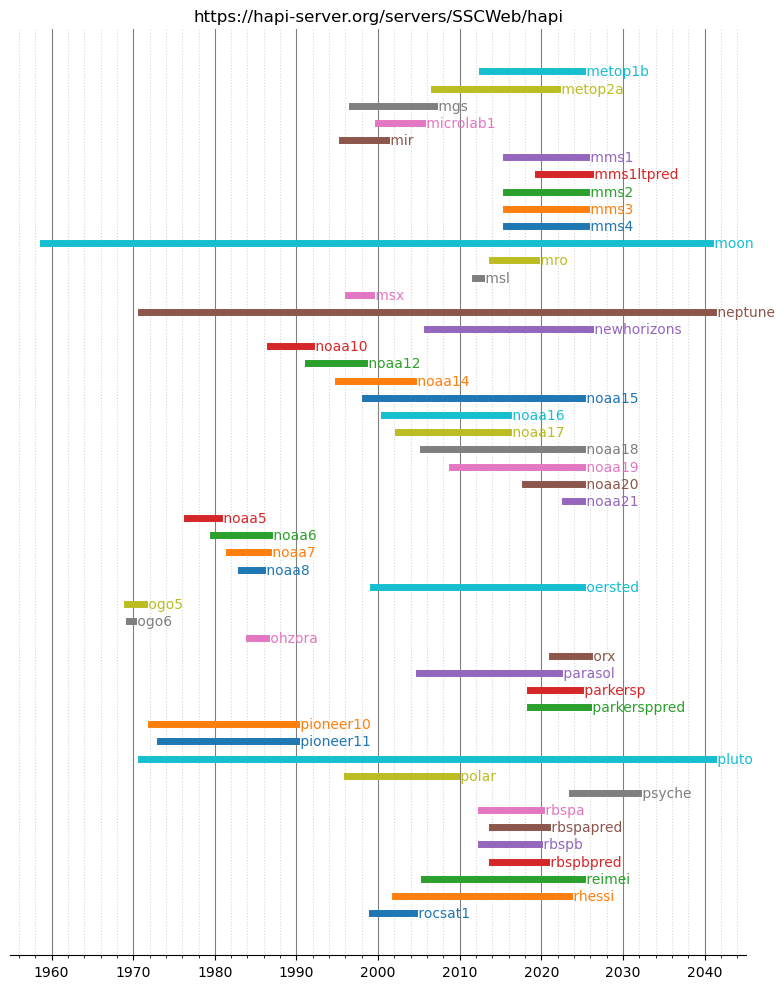

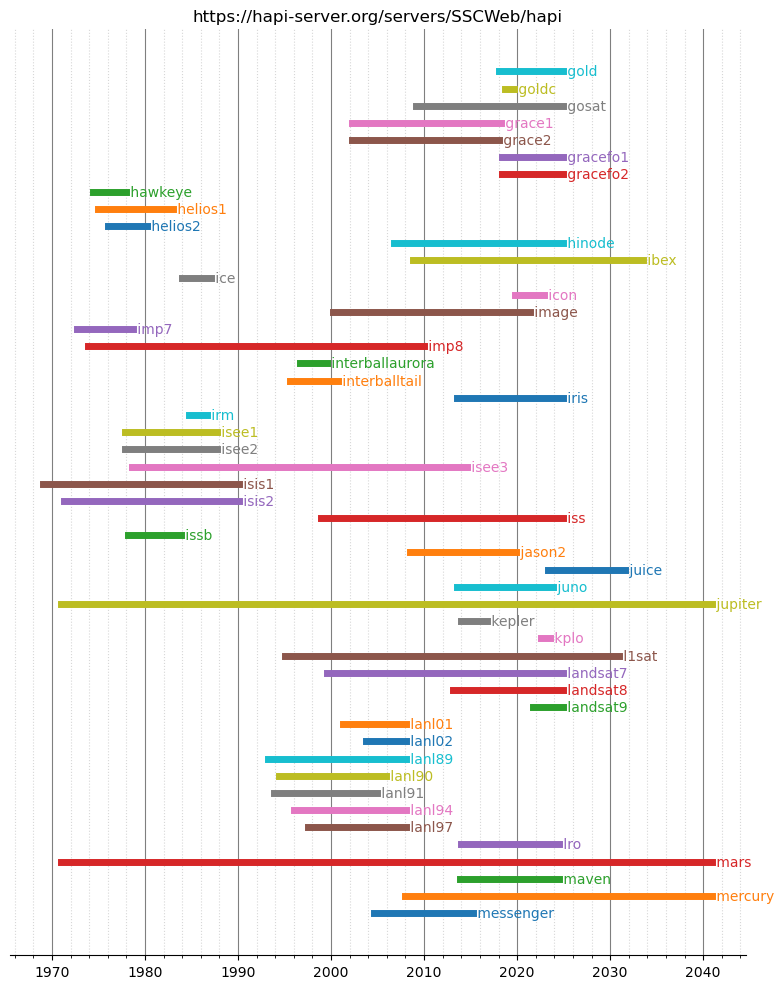

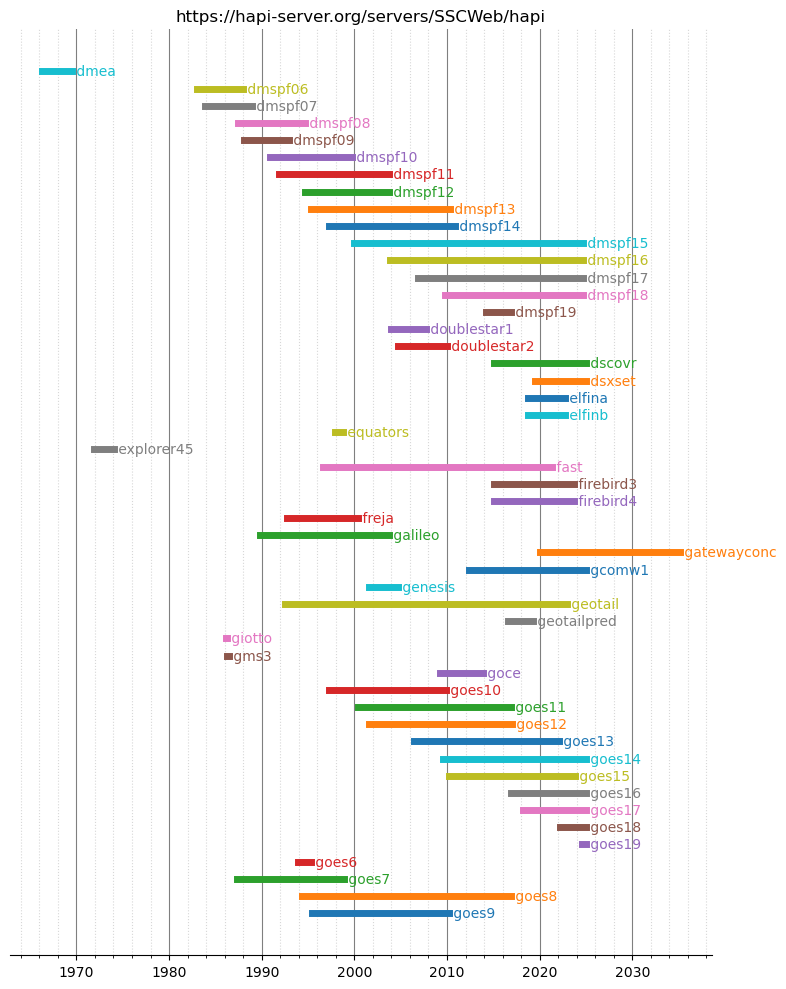

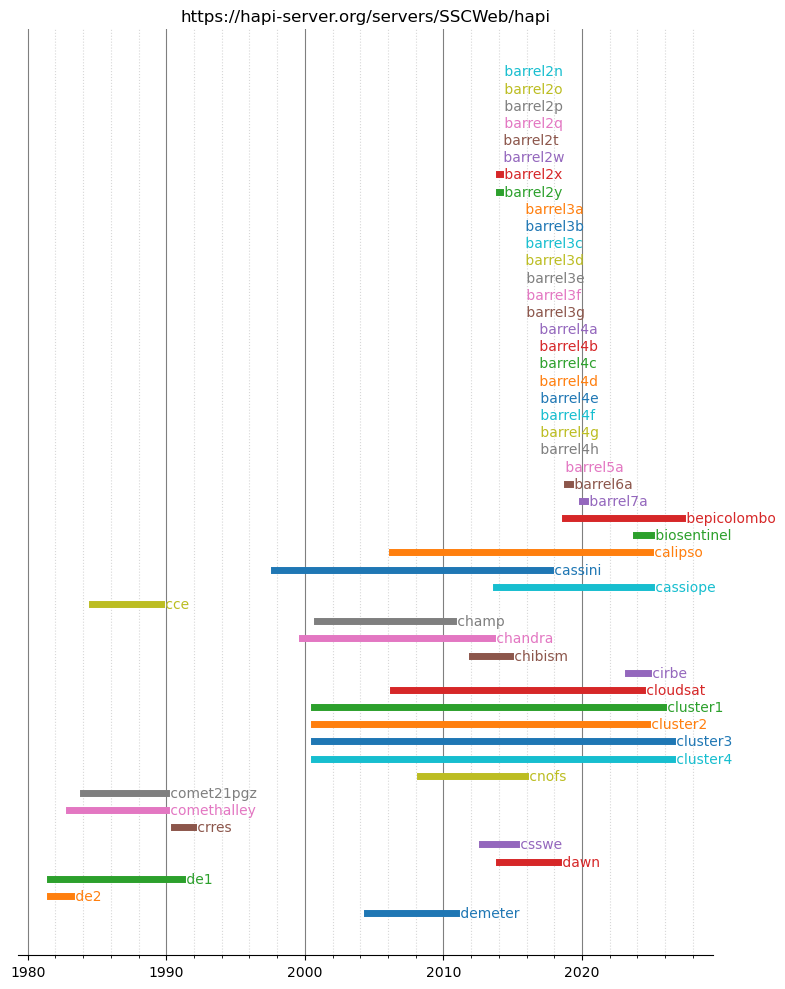

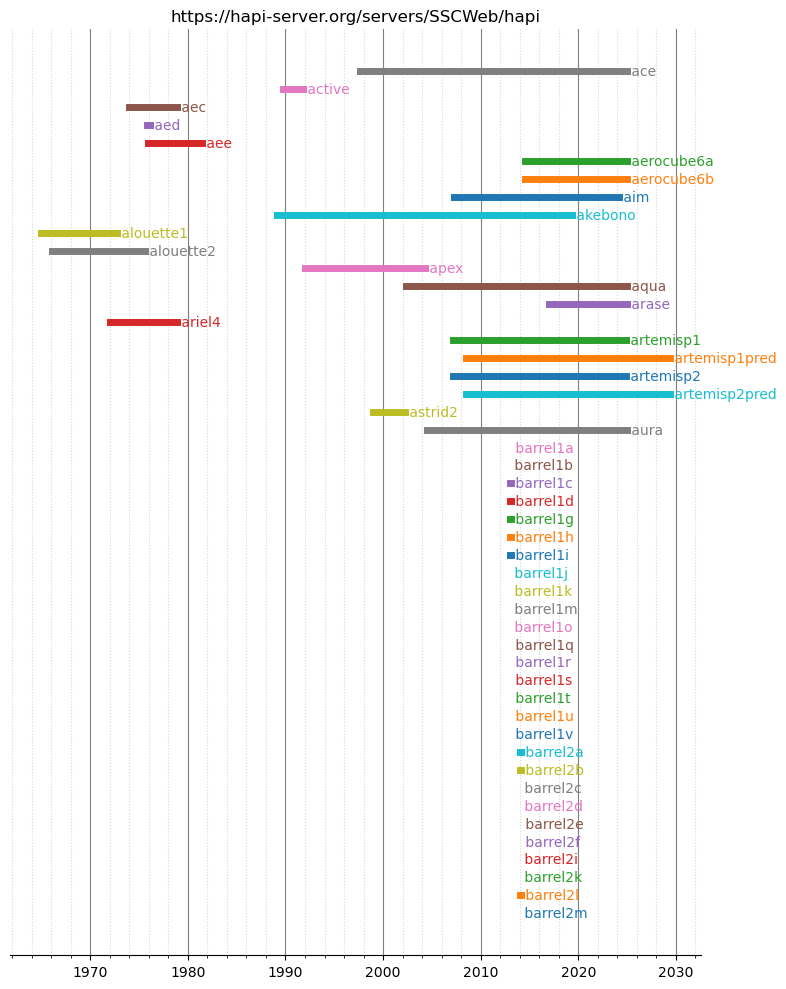

In [ ]:
idx = []
ax = newfig()
fn = 1
for n in range(len(ids)):
    line, = ax.plot([starts[n], stops[n]], [n, n], linewidth=5)
    lc = line.get_color()
    idx.append(n)
    ax.text(stops[n], n, ' ' + ids[n], color=lc, verticalalignment='center')
    if (n + 1) % 50 == 0:
        figconfig(ax)
        plt.tight_layout()
        fname = f"./availability-{fn}.svg"
        plt.savefig(fname, bbox_inches='tight')
        fn = fn + 1
        ax = newfig()

if (n + 1) % 50 != 0:
    figconfig(ax)
    plt.tight_layout()
    plt.savefig(f"./availability-{fn}.svg", bbox_inches='tight')

## Spacecraft region

Create a table that indicates the [spacecraft region](https://sscweb.gsfc.nasa.gov/users_guide/ssc_reg_doc.shtml) on `2003-10-31T23:00:00Z` for `ace`, `akebono`, `apex`, and `aqua` from SSCWeb. Your table should have columns of `Spacecraft ID`, `Region`, and `Time`, corresponding to the first time value on or after `start` as shown below.


```
--------------------------------------------------------------------------------
S/C ID           Region        Time

ace              Intpl_Med	 2003-304T23:00:00Z
akebono          D_Psphere	 2003-304T23:00:00Z
apex             D_Msphere	 2003-304T23:00:00Z
aqua             N_Psphere	 2003-304T23:00:00Z
--------------------------------------------------------------------------------
```


- Spacecraft_Region: Such a region (3-dimensional zone) is based on the spacecraft's position within the magnetosphere. A spacecraft can occupy only one region of this region type at any given time. A spacecraft region assignment can be one of the following: Interplanetary medium, Dayside Magnetosheath, Nightside Magnetosheath, Dayside Magnetosphere, Nightside Magnetosphere, Dayside Plasmasphere, Nightside Plasmasphere, Plasma Sheet, Tail Lobe, LLBL (Low Latitude Boundry Layer), HLBL (High Latitude Boundry Layer - formerly known as the Mantle)",

In [ ]:
from hapiclient import hapi

datasets = [{'id': 'ace'}, {'id': 'akebono'}, {'id': 'apex'}, {'id': 'aqua'}]

server     = 'https://hapi-server.org/servers/SSCWeb/hapi'
parameters = 'Spacecraft_Region'
start      = "2003-10-31T23:00:00Z"
stop       = "2003-10-31T23:59:00Z"
opts       = {'logging': False, 'usecache': True, 'cachedir': './cachedir'}

for dataset in datasets:
    data, meta = hapi(server, dataset['id'], parameters, start, stop, **opts)
    dataset['data'] = data

In [ ]:
import pandas as pd 

df = pd.DataFrame()
df['S/C ID'] = [dataset['id'] for dataset in datasets]
df['Region'] = [dataset['data'][0]['Spacecraft_Region'] for dataset in datasets]
df['Time'] = [dataset['data'][0]['Time'].astype('U') for dataset in datasets]
df

,S/C ID,Region,Time
0,ace,Intpl_Med,2003-304T23:00:00Z
1,akebono,D_Psphere,2003-304T23:00:00Z
2,apex,D_Msphere,2003-304T23:00:00Z
3,aqua,N_Psphere,2003-304T23:00:00Z


## Interpolating Time

For analysis, it is often useful to place two datasets that have different timestamps on the same time grid. 

There are many ways to do this, for example,

* Convert the timestamps in the NumPy `ndarray` returned by `hapi()` into integers, create a 1-D array of time integers to interpolate on to, and then either write your own interpolation function (not recommended) or use an interpolation function in [NumPy](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) or [SciPy](https://docs.scipy.org/doc/scipy/reference/interpolate.html). Converting HAPI timestamps to `datetime` objects was done by `hapitime2datetime`; one can use [`datetime` methods](https://docs.python.org/3/library/datetime.html) to convert `datetime` objects into integers.


* Place data in a Pandas `DataFrame` and use its interpolation methods.


* In the [SpacePy](https://github.com/heliophysicsPy/summer-school/blob/main/spacepy-tutorial/SpacePy%20-%20MMS%20Ephemeris.md) tutorial (search on `tb.inter`) on Day 2, you used the [`interpol`](https://spacepy.github.io/autosummary/spacepy.toolbox.interpol.html#spacepy.toolbox.interpol) function in [`spacepy.toolbox`](https://spacepy.github.io/toolbox.html) to perform interpolation.

Starting with the following program that reads datasets from two different data servers, use any library (or your own code) to

1. write a program that interpolates `data2` on to the time grid of `data0` and

2. create a table or plot that allows one to visually compare the interpolated values with the given values.

Optionally,

3. Write a program that averages `data0` into 1-hour time bins and compares the result with the contents of `data2`.

- https://cdaweb.gsfc.nasa.gov/misc/NotesA.html

- AC_H0_SWE: ACE/SWEPAM Solar Wind Experiment 64-Second Level 2 Data - D. J. McComas (SWRI)
- AC_H2_SWE: ACE/SWEPAM Solar Wind Experiment 1-Hour Level 2 Data - D. J. McComas (SWRI)

- Solar Wind Proton Number Density, scalar [Np]: Np is the proton number density in units of cm-3, as calculated by integrating the ion distribution function.

In [ ]:
from hapiclient import hapi, hapitime2datetime

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'AC_H0_SWE'
parameters = 'Np'
start      = '1998-02-04'
stop       = '1998-02-06'

data0, meta0 = hapi(server, dataset, parameters, start, stop)
print('data0 = ')
print(len(data0))
print(data0[:5])

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'AC_H2_SWE'
parameters = 'Np'
start      = '1998-02-04'
stop       = '1998-02-06'

data2, meta2 = hapi(server, dataset, parameters, start, stop)
print('\ndata2 = ')
print(len(data2))
print(data2[:5])

data0 = 
2700
[(b'1998-02-04T00:00:31.000Z', -1.e+31)
 (b'1998-02-04T00:01:35.000Z', -1.e+31)
 (b'1998-02-04T00:02:39.000Z', -1.e+31)
 (b'1998-02-04T00:03:43.000Z', -1.e+31)
 (b'1998-02-04T00:04:47.000Z', -1.e+31)]

data2 = 
48
[(b'1998-02-04T00:00:00.000Z', -1.e+31)
 (b'1998-02-04T01:00:00.000Z', -1.e+31)
 (b'1998-02-04T02:00:00.000Z', -1.e+31)
 (b'1998-02-04T03:00:00.000Z', -1.e+31)
 (b'1998-02-04T04:00:00.000Z', -1.e+31)]


In [ ]:
from hapiplot import hapiplot

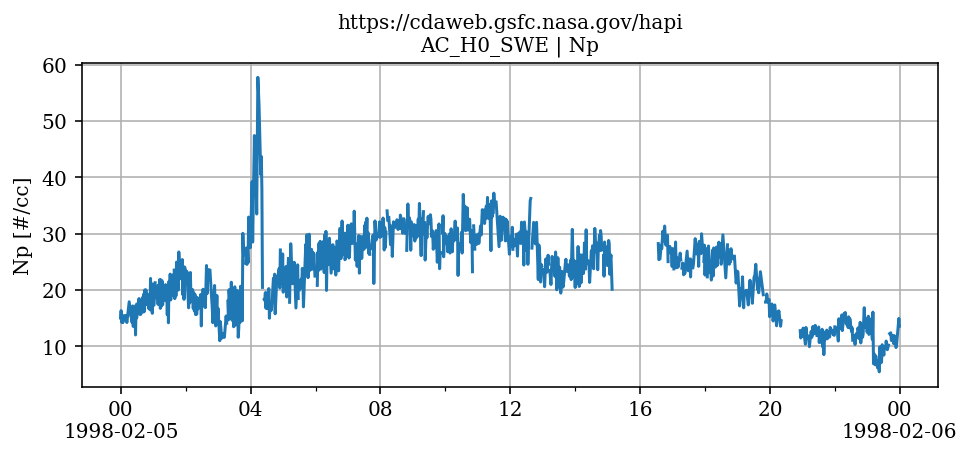

In [ ]:
hapiplot(data0, meta0);

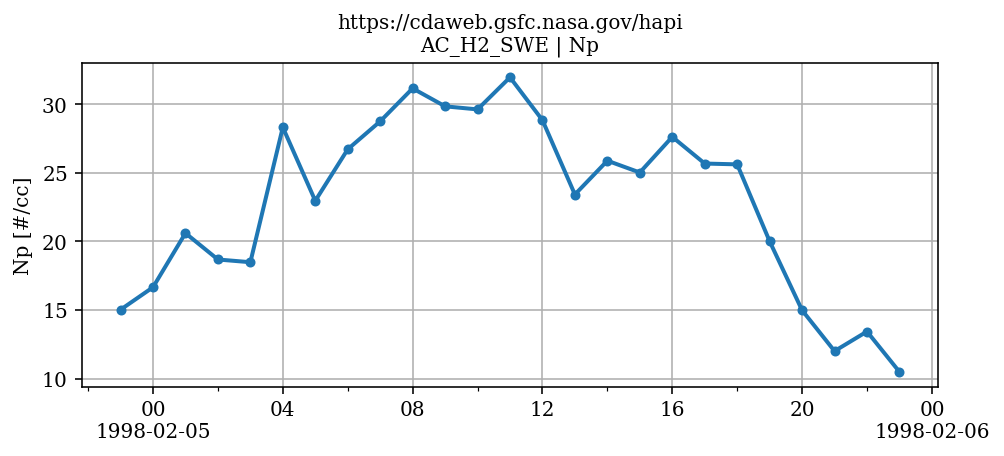

In [ ]:
hapiplot(data2, meta2);

In [ ]:
from datetime import timezone

In [ ]:
def convert_to_seconds(t):
    return np.array([(hapitime2datetime(tt)[0]-datetime(1998, 1, 1, tzinfo=timezone.utc)).total_seconds() for tt in t])

In [ ]:
data0['Time']

array([b'1998-02-04T00:00:31.000Z', b'1998-02-04T00:01:35.000Z',
       b'1998-02-04T00:02:39.000Z', ..., b'1998-02-05T23:57:19.000Z',
       b'1998-02-05T23:58:23.000Z', b'1998-02-05T23:59:27.000Z'],
      dtype='|S24')

In [ ]:
data0_times = convert_to_seconds(data0['Time'])
data0_times

array([2937631., 2937695., 2937759., ..., 3110239., 3110303., 3110367.])

In [ ]:
data0_value = data0['Np']
data0_value

array([        nan,         nan,         nan, ..., 14.48190022,
       14.94830036, 13.57830048])

In [ ]:
data2_times = convert_to_seconds(data2['Time'])
data2_times.shape

(48,)

In [ ]:
data2_value = data2['Np']
data2_value.shape

(48,)

In [ ]:
data2_value_data0_times = np.interp(data0_times, data2_times, data2_value)
data2_value_data0_times

array([        nan,         nan,         nan, ..., 10.48620033,
       10.48620033, 10.48620033])

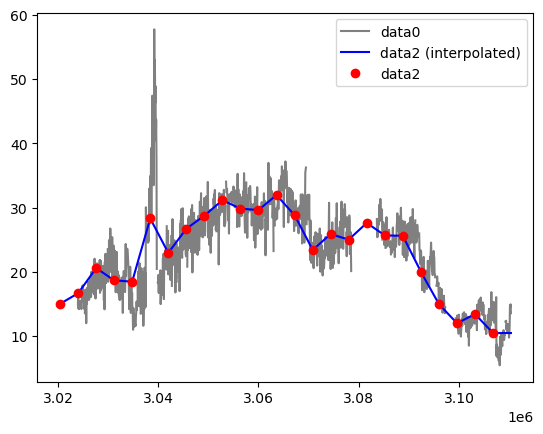

In [ ]:
plt.plot(data0_times, data0_value, label='data0', color='gray')
plt.plot(data0_times, data2_value_data0_times, label='data2 (interpolated)', color='blue')
plt.plot(data2_times, data2_value, 'o', label='data2', color='red')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

df0_Time = pd.DataFrame(hapitime2datetime(data0['Time']))
df0_Np = pd.DataFrame(data0['Np'])
df0 = pd.concat([df0_Time, df0_Np], axis=1)
df0.columns = ['Time', 'Np']
df0.set_index('Time', inplace=True)
display(df0.tail())

df2_Time = pd.DataFrame(hapitime2datetime(data2['Time']))
df2_Np = pd.DataFrame(data2['Np'])
df2 = pd.concat([df2_Time, df2_Np], axis=1)
df2.columns = ['Time', 'Np']
df2.set_index('Time', inplace=True)
display(df2.tail())

,Np
Time,
1998-02-05 23:55:11+00:00,11.5375
1998-02-05 23:56:15+00:00,14.8053
1998-02-05 23:57:19+00:00,14.4819
1998-02-05 23:58:23+00:00,14.9483
1998-02-05 23:59:27+00:00,13.5783


,Np
Time,
1998-02-05 19:00:00+00:00,20.007999
1998-02-05 20:00:00+00:00,14.978600
1998-02-05 21:00:00+00:00,12.000800
1998-02-05 22:00:00+00:00,13.428700
1998-02-05 23:00:00+00:00,10.486200


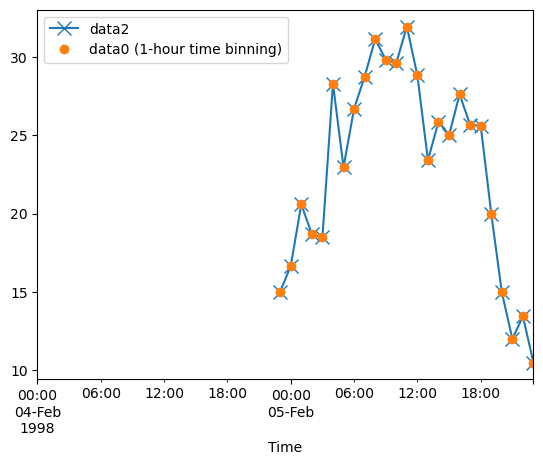

In [ ]:
fig, ax = plt.subplots()
df2.plot(ax=ax, style='x-', markersize=10)
df0.resample('1H').mean().plot(ax=ax, style='o')
ax.legend(["data2", "data0 (1-hour time binning)"])
plt.show()